In [1]:
#ver4 weighted loss function, no random rescale, 
#ver8 back to 0.821 mode, with weighted mse loss, blur
#ver10 resize 328, -> overtime


In [2]:
!pip install torch==1.1.0

     |████████████████████████████████| 676.9MB 55kB/s 
ERROR: allennlp 0.8.4 requires awscli>=1.11.91, which is not installed.
ERROR: allennlp 0.8.4 requires flaky, which is not installed.
ERROR: allennlp 0.8.4 requires responses>=0.7, which is not installed.
  Found existing installation: torch 1.2.0
    Uninstalling torch-1.2.0:
      Successfully uninstalled torch-1.2.0


In [3]:
! pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/nvidiaapex/repository/NVIDIA-apex-39e153a

/opt/conda/lib/python3.6/site-packages/pip/_internal/commands/install.py:243: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-m7in3fws
Created temporary directory: /tmp/pip-req-tracker-yalcmiok
Created requirements tracker '/tmp/pip-req-tracker-yalcmiok'
Created temporary directory: /tmp/pip-install-aa9_dti7
Processing /kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a
  Created temporary directory: /tmp/pip-req-build-6x08cwsx
  Added file:///kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a to build tracker '/tmp/pip-req-tracker-yalcmiok'
    Running setup.py (path:/tmp/pip-req-build-6x08cwsx/setup.py) egg_info for package from file:///kaggle/input/nvidiaapex/repository/NVIDIA-apex-39e153a
    Running command python setup.py egg_info
    torch.__version__  =  1.1.0
    running egg_info
    creating pip-egg

In [4]:
import cv2
import matplotlib.pyplot as plt
from os.path import isfile
import torch.nn.init as init
import torch
import torch.nn as nn
import numpy as np
import pandas as pd 
import os
from PIL import Image, ImageFilter
print(os.listdir("../input"))
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset
from torchvision import transforms
from torch.optim import Adam, SGD, RMSprop
from tqdm import tqdm
import time
from torch.autograd import Variable
import torch.functional as F
from tqdm import tqdm
from sklearn import metrics
import urllib
import pickle
import cv2
import torch.nn.functional as F
from torchvision import models
import seaborn as sns
import random
from apex import amp
import hashlib
from joblib import Parallel, delayed
import psutil
import sys
import warnings
warnings.filterwarnings('ignore')

['nvidiaapex', 'resized-2015-2019-blindness-detection-images', 'efficientnet-b6-b7', 'aptos2019-blindness-detection', 'efficientnet', 'retinopathy-train-2015', 'efficientnet-pytorch']


In [5]:
from albumentations import (
    RandomBrightnessContrast,
    Compose, RandomSizedCrop,RandomSunFlare,ShiftScaleRotate, Cutout,CLAHE,Transpose,
    OneOf,MotionBlur,Blur, MedianBlur,IAAAdditiveGaussianNoise, GaussNoise,
    GaussianBlur,RGBShift,RandomScale,HorizontalFlip,VerticalFlip,Rotate
)

In [6]:
package_path = '../input/efficientnet/efficientnet-pytorch/EfficientNet-PyTorch/'
sys.path.append(package_path)

In [7]:
from efficientnet_pytorch import EfficientNet

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [9]:
seed_everything(1234)
basic_model        = 'B5'
num_classes        = 1
lr                 = 1e-3
IMG_SIZE           = 328
n_epochs           = 25
snapshot           = 1
train_batch_size   = 32
test_batch_size    = 64
step_size          = 5
accumulation_steps = 2

In [10]:
#train      = '../input/resized-2015-2019-blindness-detection-images/resized train 19/'
#test       = '../input/resized-2015-2019-blindness-detection-images/resized test 15/'
#train_2015 = '../input/resized-2015-2019-blindness-detection-images/resized train 15/'

#train_csv      = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
#train_2015_csv = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/trainLabels15.csv')
#test_2015_csv  = pd.read_csv('../input/resized-2015-2019-blindness-detection-images/labels/testLabels15.csv').drop(['Usage'], axis=1)

#train_2015_csv.columns = ['id_code', 'diagnosis']
#test_2015_csv.columns = ['id_code', 'diagnosis']
#train_all = pd.concat([train_csv, train_2015_csv, test_2015_csv])
#train_all.reset_index(drop=True, inplace=True)

In [11]:
train      = '../input/aptos2019-blindness-detection/train_images/'
test       = '../input/aptos2019-blindness-detection/test_images/'
train_2015 = '../input/retinopathy-train-2015/rescaled_train_896/rescaled_train_896/'
train_csv      = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
train_2015_csv = pd.read_csv('../input/retinopathy-train-2015/rescaled_train_896/trainLabels.csv')
train_2015_csv.columns = ['id_code', 'diagnosis']
train_all = pd.concat([train_csv, train_2015_csv])
train_all.reset_index(drop=True, inplace=True)

In [12]:
def expand_path(p):
    p = str(p)
    if isfile(train + p + ".png"):
        return train + (p + ".png")
    if isfile(train_2015 + p + '.png'):
        return train_2015 + (p + ".png")
    if isfile(test + p + ".png"):
        return test + (p + ".png")
    return p

def expand_pathV2(p):
    p = str(p)
    if isfile(train + p + ".jpg"):
        return train + (p + ".jpg")
    if isfile(train_2015 + p + '.jpg'):
        return train_2015 + (p + ".jpg")
    if isfile(test + p + ".jpg"):
        return test + (p + ".jpg")
    return p

def p_show(imgs, label_name=None, per_row=3):
    n = len(imgs)
    rows = (n + per_row - 1)//per_row
    cols = min(per_row, n)
    fig, axes = plt.subplots(rows,cols, figsize=(15,15))
    for ax in axes.flatten(): ax.axis('off')
    for i,(p, ax) in enumerate(zip(imgs, axes.flatten())): 
        img = Image.open(expand_path(p))
        ax.imshow(img)
        ax.set_title(train_df[train_df.id_code == p].diagnosis.values)

In [13]:
def getImageMetaData(p):
    
    strFile = expand_path(p)
    file = None;
    bRet = False;
    strMd5 = "";
    
    try:
        file = open(strFile, "rb");
        md5 = hashlib.md5();
        strRead = "";
        
        while True:
            strRead = file.read(8096);
            if not strRead:
                break;
            md5.update(strRead);
        #read file finish
        bRet = True;
        strMd5 = md5.hexdigest();
    except:
        bRet = False;
    finally:
        if file:
            file.close()

    return p,strMd5

img_meta_l = Parallel(n_jobs=psutil.cpu_count(), verbose=1)((delayed(getImageMetaData)(fp) for fp in train_all.id_code))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 715 tasks      | elapsed:    4.7s
[Parallel(n_jobs=2)]: Done 4915 tasks      | elapsed:   26.0s
[Parallel(n_jobs=2)]: Done 11915 tasks      | elapsed:   43.6s
[Parallel(n_jobs=2)]: Done 21715 tasks      | elapsed:  1.1min
[Parallel(n_jobs=2)]: Done 34315 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 38788 out of 38788 | elapsed:  1.9min finished


In [14]:
img_meta_df = pd.DataFrame(np.array(img_meta_l))
img_meta_df.columns = ['id_code', 'strMd5']
train_all = train_all.merge(img_meta_df,on='id_code')
train_all.head()

,id_code,diagnosis,strMd5
0,000c1434d8d7,2,e6155d8339d40577f97a5ce270aa81d1
1,001639a390f0,4,8f98205b18dfcc9111fe97037d9fe5ba
2,0024cdab0c1e,1,43e417a95e1259bc318493e399670cb8
3,002c21358ce6,0,f96db7f8fc458a804b0db13739bc976d
4,005b95c28852,0,17ecb0becd4bd280b3572ad31dce75b9


In [15]:
train_all['strMd5_count'] = train_all.groupby('strMd5').id_code.transform('count')
train_all['strMd5_nunique'] = train_all.groupby('strMd5')['diagnosis'].transform('nunique').astype('int')
train_all[train_all.strMd5_count>1].strMd5_count.value_counts()

train_duplicated = train_all[(train_all.strMd5_count>1)]
print('There are {} deplicated pictures.'.format(len(train_duplicated)))
diagnosis_no_unique = train_duplicated[train_duplicated.strMd5_nunique != 1]
print('There are {} deplicated pictures with different dignosis.'.format(len(diagnosis_no_unique)))
diagnosis_unique = train_duplicated[train_duplicated.strMd5_nunique == 1]
strMd5_dict = {}
for strMd5 in diagnosis_unique.strMd5.values:
    id_codes = list(diagnosis_unique[diagnosis_unique.strMd5 == strMd5].id_code.values)
    strMd5_dict[strMd5] = id_codes

train2clear = train_all.set_index('id_code')
print('before:', len(train2clear))
left_image = 1
for strMd5, id_codes in strMd5_dict.items():
    num_images = len(id_codes)
    num_delete = num_images - left_image
    delete_id_code = random.sample(id_codes, num_delete)
    train2clear = train2clear.drop(delete_id_code)
print('after:', len(train2clear))

There are 251 deplicated pictures.
There are 62 deplicated pictures with different dignosis.
before: 38788
after: 38692


In [16]:
train2clear.reset_index(drop=False, inplace=True)
train_df, val_df = train_test_split(train2clear, test_size=0.1, random_state=2018, stratify=train2clear.diagnosis)
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
train_df.head()

,id_code,diagnosis,strMd5,strMd5_count,strMd5_nunique
0,28f73575e1f2,0,f098cbb45e3442036a76a2e446f2c7d0,1,1
1,40749_right,0,3182f0f791f6a9095fe6a2c8962f3f40,1,1
2,17387_left,2,1066a9173de6adece2314bbdd83b233a,1,1
3,17719_right,0,792585889e8a984b0df812eb94b0f9e0,1,1
4,39747_left,4,3dd2d639e307cdaf022c554c44b10141,1,1


## Data Argument

In [17]:
import h5py
from multiprocessing import Pool
from itertools import repeat
from timeit import default_timer as timer

In [18]:
max_hole_size = int(IMG_SIZE/20)

In [19]:
AUGMENTATIONS_TRAIN = Compose([#CLAHE(clip_limit=2, p=0.5),
                               OneOf([
                                   Blur(blur_limit=3, p=0.2),
                                   MedianBlur(blur_limit=3, p=0.2),
                                   GaussianBlur(blur_limit=3, p=0.2)], p=0.5),
                               RandomBrightnessContrast(brightness_limit=0.45, contrast_limit=0.45, p=0.5),
                               #Cutout(p=0.5,max_h_size=max_hole_size,max_w_size=max_hole_size,num_holes=8)
                              ])

In [20]:
def toCLAHEgreen(img):  
    clipLimit=2.0 
    tileGridSize=(8, 8)  
    img = np.array(img)     
    green_channel = img[:, :, 1]    
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    cla = clahe.apply(green_channel) 
    
    return cla

In [21]:
def crop_image_from_gray(img,tol=7):
    """
    Crop out black borders
    https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping
    """  
    
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img


def circle_crop(img, prob=0.6):   
    """
    Create circular crop around image centre
    """
    
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray_img.shape
    
    if np.count_nonzero(gray_img) > int(h*w*prob):
        return img
    
    img = crop_image_from_gray(img)
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    
    return img 

In [22]:
class MyDataset(Dataset):
    
    def __init__(self, dataframe, h5_file_name, argument=None, transform=None):
        self.df = dataframe
        self.transform = transform
        self.argument  = argument
        self.h5_file_name = h5_file_name
        
        with h5py.File(h5_file_name, 'r') as hdf5_file:
            self.image_names_in_h5 = np.array(hdf5_file.get('id_code')) 
            
        self.h5_dataset = None
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        label = self.df.diagnosis.values[idx]
        label = np.expand_dims(label, -1)
        
        image_name = self.df.id_code.values[idx]
        image_idx_in_h5 = np.where(self.image_names_in_h5 == image_name.encode())[0][0] 
        if self.h5_dataset is None:
            self.h5_dataset = h5py.File(self.h5_file_name, 'r')['images']
        image = self.h5_dataset[image_idx_in_h5]
        #image[:, :, 1] = toCLAHEgreen(image)
        
        if self.argument:
            augmented = self.argument(image=image)
            image = augmented['image']
            image = transforms.ToPILImage()(image.astype(np.uint8))
        else:
            image = transforms.ToPILImage()(image)

        if self.transform:
            image = self.transform(image)
        
        return image, label

In [23]:
def resize_images(img, desired_size = 1024):
    try:
    
        img = cv2.copyMakeBorder(img,10,10,10,10,cv2.BORDER_CONSTANT,value=[0,0,0])
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret,gray = cv2.threshold(gray,10,255,cv2.THRESH_BINARY)
    
        contours,hierarchy = cv2.findContours(gray,
                                              cv2.RETR_EXTERNAL,
                                              cv2.CHAIN_APPROX_SIMPLE)
        contours = max(contours, key=cv2.contourArea)
        x,y,w,h = cv2.boundingRect(contours)

        if w>200 and h>200:
            new_img = img[y:y+h,x:x+w]
            height, width, _= new_img.shape

            if max([height, width]) > desired_size:
                ratio = float(desired_size/max([height, width]))
                new_img = cv2.resize(new_img, 
                                 tuple([int(width*ratio), int(height*ratio)]), 
                                 interpolation = cv2.INTER_CUBIC)
            return new_img
        else:
            return img
    except:
        return img

In [24]:
class MyDatasetV2(Dataset):
    
    def __init__(self, dataframe, resize=True, argument=None, transform=None):
        self.df        = dataframe
        self.resize    = resize
        self.transform = transform
        self.argument  = argument
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        
        label = self.df.diagnosis.values[idx]
        label = np.expand_dims(label, -1)
        
        p      = self.df.id_code.values[idx]
        p_path = expand_path(p)
        image  = cv2.imread(p_path)
        image  = resize_images(image)
        image  = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image  = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        
        if self.argument:
            augmented = self.argument(image=image)
            image     = augmented['image']
        
        image = transforms.ToPILImage()(image.astype(np.uint8))
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [25]:
train_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.45, contrast=0.45),
    transforms.RandomAffine(degrees=360, scale=(1.0, 1.3)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.45, contrast=0.45),
    transforms.RandomAffine(degrees=0, scale=(1.0, 1.3)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

trainset     = MyDatasetV2(train_df, transform = train_transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size, shuffle=True, num_workers=4)
valset       = MyDatasetV2(val_df, transform = val_transform)
val_loader   = torch.utils.data.DataLoader(valset, batch_size=test_batch_size, shuffle=False, num_workers=4)

In [26]:
plot = True
import time

CPU times: user 628 ms, sys: 12 ms, total: 640 ms
Wall time: 733 ms


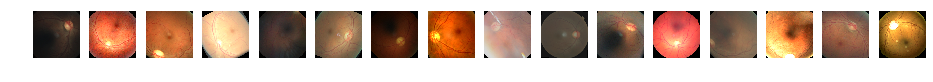

In [27]:
%%time
if plot:
    max_images = 16
    grid_width = 16
    grid_height = int(max_images / grid_width)
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
    plot_transform = transforms.Compose([
                     transforms.ColorJitter(brightness=0.45, contrast=0.45),
                     transforms.RandomAffine(degrees=360, scale=(1.0, 1.3)),
                     transforms.RandomHorizontalFlip(),
                     transforms.RandomVerticalFlip(),
                     transforms.ToTensor()])
    plot_dataset  = MyDatasetV2(train_df, transform = plot_transform, argument=AUGMENTATIONS_TRAIN)
    for i, ax in zip(range(1000, 1000+max_images), axs):
        image, label = plot_dataset[i]
        ax.imshow(transforms.ToPILImage()(image))
        ax.axis('off')

CPU times: user 688 ms, sys: 32 ms, total: 720 ms
Wall time: 714 ms


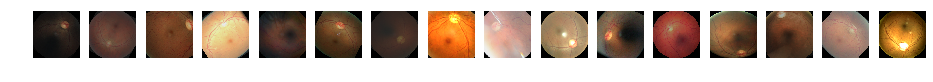

In [28]:
%%time
if plot:
    max_images = 16
    grid_width = 16
    grid_height = int(max_images / grid_width)
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
    plot_dataset  = MyDatasetV2(train_df, transform = plot_transform, argument=AUGMENTATIONS_TRAIN, resize=False)
    for i, ax in zip(range(1000, 1000+max_images), axs):
        image, label = plot_dataset[i]
        ax.imshow(transforms.ToPILImage()(image))
        ax.axis('off')

In [29]:
if basic_model == "B5": 
    model = EfficientNet.from_name('efficientnet-b5')
    model.load_state_dict(torch.load('../input/efficientnet-pytorch/efficientnet-b5-586e6cc6.pth'))
elif basic_model == "B4":
    model = EfficientNet.from_name('efficientnet-b4')
    model.load_state_dict(torch.load('../input/efficientnet-pytorch/efficientnet-b4-e116e8b3.pth'))
in_features = model._fc.in_features
model._fc   = nn.Sequential(nn.Dropout(0.5), nn.Linear(in_features, num_classes))
model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_siz

In [30]:
from torch.optim.lr_scheduler import LambdaLR
import math

class WarmupCosineSchedule(LambdaLR):
    """ Linear warmup and then cosine decay.
        Linearly increases learning rate from 0 to 1 over `warmup_steps` training steps.
        Decreases learning rate from 1. to 0. over remaining `t_total - warmup_steps` steps following a cosine curve.
        If `cycles` (default=0.5) is different from default, learning rate follows cosine function after warmup.
    """
    def __init__(self, optimizer, warmup_steps, t_total, cycles=.5, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.t_total = t_total
        self.cycles = cycles
        super(WarmupCosineSchedule, self).__init__(optimizer, self.lr_lambda, last_epoch=last_epoch)

    def lr_lambda(self, step):
        if step < self.warmup_steps:
            return float(step) / float(max(1.0, self.warmup_steps))
        # progress after warmup
        progress = float(step - self.warmup_steps) / float(max(1, self.t_total - self.warmup_steps))
        return max(0.0, 0.5 * (1. + math.cos(math.pi * float(self.cycles) * 2.0 * progress)))

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)
criterion = nn.MSELoss() 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=0.5)
model, optimizer = amp.initialize(model, optimizer, opt_level="O1",verbosity=0)

In [32]:
def convert_output(output):
    coef = [0.5, 1.5, 2.5, 3.5]
    for i, pred in enumerate(output):
        if pred < coef[0]:
            output[i] = 0
        elif pred >= coef[0] and pred < coef[1]:
            output[i] = 1
        elif pred >= coef[1] and pred < coef[2]:
            output[i] = 2
        elif pred >= coef[2] and pred < coef[3]:
            output[i] = 3
        else:
            output[i] = 4
            
    return output

In [33]:
from sklearn.metrics import cohen_kappa_score 

In [34]:
def train_model(epoch):
    
    model.train()
    avg_loss = 0.
    optimizer.zero_grad()
    for idx, (imgs, labels) in enumerate(train_loader):
        imgs_train, labels_train = imgs.cuda(), labels.float().cuda()
        output_train = model(imgs_train)
        loss = criterion(output_train,labels_train)
        with amp.scale_loss(loss, optimizer) as scaled_loss:
            scaled_loss.backward()
        if (idx+1) % accumulation_steps == 0:             # Wait for several backward steps
            optimizer.step()                              # Now we can do an optimizer step
            optimizer.zero_grad()
        avg_loss += loss.item() / len(train_loader)
        
    return avg_loss

def test_model():
    
    avg_val_loss = 0.
    predicts = np.zeros(len(valset))
    truths   = np.zeros(len(valset))
    
    model.eval() 
    with torch.no_grad():
        for idx, (imgs, labels) in enumerate(val_loader):
            start = idx*test_batch_size
            end   = min(start + test_batch_size, len(valset))
            imgs_val, labels_val = imgs.cuda(), labels.float().cuda()
            output_test = model(imgs_val)
            avg_val_loss += criterion(output_test, labels_val).item() / len(val_loader)
            
            predicts[start:end] =  output_test.detach().cpu().numpy().flatten()
            truths[start:end]=  labels_val.detach().cpu().numpy().flatten()
            
    score = cohen_kappa_score(np.array(truths), convert_output(predicts), weights='quadratic')
    
    return avg_val_loss, score

In [35]:
best_avg_loss = 100.0
best_acc      = 0.0
i = 0

for epoch in range(n_epochs):
    
    
    if i == 5: break
    print(optimizer.param_groups[0]['lr'])
    start_time   = time.time()
    avg_loss     = train_model(epoch)
    avg_val_loss, score = test_model()
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t score={:.4f} \t time={:.2f}s'.format(
        epoch + 1, n_epochs, avg_loss, avg_val_loss, score, elapsed_time))
    
    if best_avg_loss > avg_val_loss:
        i = 0
        best_avg_loss = avg_val_loss 
        best_param_loss = model.state_dict()
    else:
        i += 1
    
    if score > best_acc:
        best_acc = score
        best_param_acc = model.state_dict()

    scheduler.step()
    
torch.save(best_param_loss, 'weight_loss_best.pt')
torch.save(best_param_acc, 'weight_acc_best.pt')

0.001
Epoch 1/25 	 loss=0.5551 	 val_loss=0.4895 	 score=0.7060 	 time=1265.12s
0.001
Epoch 2/25 	 loss=0.4418 	 val_loss=0.3868 	 score=0.7584 	 time=1271.43s
0.001
Epoch 3/25 	 loss=0.4085 	 val_loss=0.4008 	 score=0.7647 	 time=1269.29s
0.001
Epoch 4/25 	 loss=0.3980 	 val_loss=0.4403 	 score=0.7193 	 time=1270.40s
0.001
Epoch 5/25 	 loss=0.3664 	 val_loss=0.3498 	 score=0.7803 	 time=1251.65s
0.0005
Epoch 6/25 	 loss=0.3305 	 val_loss=0.3124 	 score=0.8103 	 time=1255.46s
0.0005
Epoch 7/25 	 loss=0.3124 	 val_loss=0.3650 	 score=0.7813 	 time=1230.50s
0.0005
Epoch 8/25 	 loss=0.3076 	 val_loss=0.3317 	 score=0.7992 	 time=1238.98s
0.0005
Epoch 9/25 	 loss=0.2998 	 val_loss=0.3122 	 score=0.8034 	 time=1233.30s
0.0005
Epoch 10/25 	 loss=0.2961 	 val_loss=0.3113 	 score=0.7987 	 time=1255.60s
0.00025
Epoch 11/25 	 loss=0.2660 	 val_loss=0.2845 	 score=0.8322 	 time=1271.82s
0.00025
Epoch 12/25 	 loss=0.2647 	 val_loss=0.2812 	 score=0.8331 	 time=1265.72s
0.00025
Epoch 13/25 	 loss=0